# Tutorial: Hybrid Attention in pulse

This tutorial explains the **Hybrid Attention** mechanism in Parallel Unified Linear State Engines (pulse), which combines local (token-token) and global (token-state) attention for comprehensive context modeling.

## Learning Objectives

By the end of this tutorial, you will understand:

1. The concept of hybrid attention in pulse
2. How local and global attention complement each other
3. The benefits of combining both attention types
4. A simple implementation of hybrid attention

## What is Hybrid Attention?

Traditional Transformers rely solely on token-token attention, which can miss global context. pulse introduces **hybrid attention** that combines:

- **Local Attention**: Captures immediate, token-level context
- **Global Attention**: Captures long-term, state-level context

This dual approach enables the model to:
- Understand fine-grained details (local)
- Maintain big-picture understanding (global)
- Balance efficiency with expressivity

## How Hybrid Attention Works

The hybrid attention process involves:

1. **Local Attention Computation**: Standard self-attention between tokens
2. **Global Attention Computation**: Attention from tokens to state nodes
3. **Context Combination**: Merging local and global contexts

Let's implement a simple example to see this in action.

In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# For better visualization
import seaborn as sns
sns.set(style="whitegrid")

print("Libraries imported successfully!")

Libraries imported successfully!


In [3]:
# Define parameters
batch_size = 1
seq_length = 6  # Number of tokens
token_dim = 16
num_states = 4
state_dim = 16

# Create random token embeddings
tokens = torch.randn(batch_size, seq_length, token_dim)

# Create random state embeddings
states = torch.randn(batch_size, num_states, state_dim)

# Create routing weights (from previous tutorial)
routing_weights = F.softmax(torch.bmm(tokens, states.transpose(1, 2)), dim=-1)

print(f"Token embeddings shape: {tokens.shape}")
print(f"State embeddings shape: {states.shape}")
print(f"Routing weights shape: {routing_weights.shape}")

Token embeddings shape: torch.Size([1, 6, 16])
State embeddings shape: torch.Size([1, 4, 16])
Routing weights shape: torch.Size([1, 6, 4])


Local context shape: torch.Size([1, 6, 16])
Local attention weights shape: torch.Size([1, 6, 6])


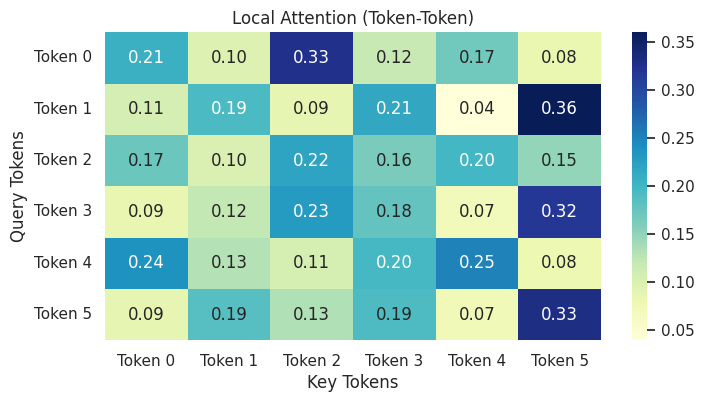

In [4]:
# Local Attention (Token-Token)

# Initialize a simple multi-head attention mechanism
local_attn = nn.MultiheadAttention(token_dim, num_heads=2, batch_first=True)

# Compute local attention
local_context, local_weights = local_attn(tokens, tokens, tokens)

print(f"Local context shape: {local_context.shape}")
print(f"Local attention weights shape: {local_weights.shape}")

# Visualize local attention for first token
plt.figure(figsize=(8, 4))
sns.heatmap(local_weights[0].detach().numpy(), annot=True, cmap="YlGnBu", fmt=".2f",
            xticklabels=[f'Token {i}' for i in range(seq_length)],
            yticklabels=[f'Token {i}' for i in range(seq_length)])
plt.title('Local Attention (Token-Token)')
plt.xlabel('Key Tokens')
plt.ylabel('Query Tokens')
plt.show()

In [5]:
# Global Attention (Token-State)

# Compute global context using routing weights
# [B, N, S] x [B, S, D_state] -> [B, N, D_state]
global_context = torch.bmm(routing_weights, states)

print(f"Global context shape: {global_context.shape}")

# Visualize global attention (routing weights)
plt.figure(figsize=(8, 4))
sns.heatmap(routing_weights[0].detach().numpy(), annot=True, cmap="YlOrRd", fmt=".2f",
            xticklabels=[f'State {i}' for i in range(num_states)],
            yticklabels=[f'Token {i}' for i in range(seq_length)])
plt.title('Global Attention (Token-State)')
plt.xlabel('State Nodes')
plt.ylabel('Tokens')
plt.show()

Global context shape: torch.Size([1, 6, 16])


In [6]:
# Combine Local and Global Context

# Simple combination: weighted sum
# In practice, this could be a more complex gating mechanism
alpha = 0.5  # Balance parameter
combined_context = alpha * local_context + (1 - alpha) * global_context

print(f"Combined context shape: {combined_context.shape}")

print("\nComparison of contexts for first token:")
print(f"Original token: {tokens[0, 0]}")
print(f"Local context: {local_context[0, 0]}")
print(f"Global context: {global_context[0, 0]}")
print(f"Combined context: {combined_context[0, 0]}")

Combined context shape: torch.Size([1, 6, 16])

Comparison of contexts for first token:
Original token: tensor([ 0.4862, -1.5599, -0.6192, -1.7152,  0.8761,  0.1170,  2.0017,  2.1566,
         0.3623,  1.0483, -0.1407, -1.0836, -1.6561,  0.9122, -0.9213, -0.1617])
Local context: tensor([-0.3114, -0.1858, -0.1499,  0.2672,  0.2761, -0.0336,  0.3004, -0.0721,
         0.0136, -0.0969, -0.0209, -0.2199,  0.1107, -0.0830, -0.1301, -0.1276],
       grad_fn=<SelectBackward0>)
Global context: tensor([-1.1707, -1.0447,  1.0575, -0.2681,  0.3059, -1.4559,  1.4202, -0.3489,
         0.7193,  0.7103,  0.3619, -0.8586,  0.0964, -0.9730,  0.0844,  0.8998])
Combined context: tensor([-7.4105e-01, -6.1525e-01,  4.5380e-01, -4.3921e-04,  2.9102e-01,
        -7.4473e-01,  8.6029e-01, -2.1052e-01,  3.6645e-01,  3.0670e-01,
         1.7050e-01, -5.3928e-01,  1.0360e-01, -5.2802e-01, -2.2876e-02,
         3.8608e-01], grad_fn=<SelectBackward0>)


## Key Takeaways

1. **Dual Context Modeling**: Hybrid attention captures both immediate (local) and long-term (global) context.
2. **Complementary Information**: Local attention handles fine-grained details, while global attention maintains big-picture understanding.
3. **Flexibility**: The combination mechanism can be learned or adjusted for different tasks.

## Next Steps

With these foundational concepts understood, you're ready to explore the full pulse architecture.

See `notebooks/research/pulse_prototype.ipynb` for a complete implementation of an pulse layer.

For a deeper dive into research aspects, check out:
- `notebooks/research/benchmarking.ipynb`: Performance comparisons
- `notebooks/research/interpretability.ipynb`: Visualization of state evolution